In [7]:
import numpy as np
import random as rd
import scipy.sparse as sp
import torch
from time import time
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import scipy.sparse as sp
from torch import nn
import pandas as pd
import os
from datetime import datetime
from scipy.stats import truncnorm
#from utils.load_data import Data
#from utils.parser import parse_args
#from utils.helper_functions import early_stopping,\
                                   #train,\
                                   #split_matrix,\
                                   #compute_ndcg_k,\
                                   #eval_model

# read parsed arguments
#args = parse_args()

#from google.colab import drive
#drive.mount('/content/drive')
#data_dir = '/content/drive/My Drive/Colab Notebooks/NGCFPytorch/data/'
data_dir = './data/'
dataset = 'Gowella'
batch_size = 1024
layers = eval('[64,64]')
emb_dim = 64
lr = 0.0001
reg = 1e-5
mess_dropout = 0.1
node_dropout = 0.
k = 20
argssave_results = 1
argsn_epochs = 201
argseval_N = 1

In [2]:
torch.cuda.is_available()
#torch. __version__

True

#1

In [3]:
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        # search train_file for max user_id/item_id
        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    # first element is the user_id, rest are items
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    # item/user with highest number is number of items/users
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    # number of interactions
                    self.n_train += len(items)

        # search test_file for max item_id
        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    if not items:
                        print("empyt test exists")
                        pass
                    else:
                        self.n_items = max(self.n_items, max(items))
                        self.n_test += len(items)
        # adjust counters: user_id/item_id starts at 0
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        # create interactions/ratings matrix 'R' # dok = dictionary of keys
        print('Creating interaction matrices R_train and R_test...')
        t1 = time()
        self.R_train = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32) 
        self.R_test = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]
                    # enter 1 if user interacted with item
                    for i in train_items:
                        self.R_train[uid, i] = 1.
                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue
                    uid, test_items = items[0], items[1:]
                    for i in test_items:
                        self.R_test[uid, i] = 1.0
                    self.test_set[uid] = test_items
        print('Complete. Interaction matrices R_train and R_test created in', time() - t1, 'sec')

    # if exist, get adjacency matrix
    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            print('Loaded adjacency-matrix (shape:', adj_mat.shape,') in', time() - t1, 'sec.')

        except Exception:
            print('Creating adjacency-matrix...')
            adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
        return adj_mat
    
    # create adjancency matrix
    def create_adj_mat(self):
        t1 = time()
        
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R_train.tolil() # to list of lists

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('Complete. Adjacency-matrix created in', adj_mat.shape, time() - t1, 'sec.')

        t2 = time()

        # normalize adjacency matrix
        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
            return norm_adj.tocoo()

        print('Transforming adjacency-matrix to NGCF-adjacency matrix...')
        ngcf_adj_mat = normalized_adj_single(adj_mat) + sp.eye(adj_mat.shape[0])

        print('Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in', time() - t2, 'sec.')
        return ngcf_adj_mat.tocsr()

    # create collections of N items that users never interacted with
    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    # sample data for mini-batches
    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num: break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = []
            while True:
                if len(neg_items) == num: break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

#2

In [4]:
def early_stopping(log_value, best_value, stopping_step, flag_step, expected_order='asc'):
    """
    Check if early_stopping is needed
    Function copied from original code
    """
    assert expected_order in ['asc', 'des']
    if (expected_order == 'asc' and log_value >= best_value) or (expected_order == 'des' and log_value <= best_value):
        stopping_step = 0
        best_value = log_value
    else:
        stopping_step += 1

    if stopping_step >= flag_step:
        print("Early stopping at step: {} log:{}".format(flag_step, log_value))
        should_stop = True
    else:
        should_stop = False

    return best_value, stopping_step, should_stop

def train(model, data_generator, optimizer):
    """
    Train the model PyTorch style

    Arguments:
    ---------
    model: PyTorch model
    data_generator: Data object
    optimizer: PyTorch optimizer
    """
    model.train()
    n_batch = data_generator.n_train // data_generator.batch_size + 1
    running_loss=0
    for _ in range(n_batch):
        u, i, j = data_generator.sample()
        optimizer.zero_grad()
        loss = model(u,i,j)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss

def split_matrix(X, n_splits=100):
    """
    Split a matrix/Tensor into n_folds (for the user embeddings and the R matrices)

    Arguments:
    ---------
    X: matrix to be split
    n_folds: number of folds

    Returns:
    -------
    splits: split matrices
    """
    splits = []
    chunk_size = X.shape[0] // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = X.shape[0] if i == n_splits - 1 else (i + 1) * chunk_size
        splits.append(X[start:end])
    return splits

def compute_ndcg_k(pred_items, test_items, test_indices, k):
    """
    Compute NDCG@k
    
    Arguments:
    ---------
    pred_items: binary tensor with 1s in those locations corresponding to the predicted item interactions
    test_items: binary tensor with 1s in locations corresponding to the real test interactions
    test_indices: tensor with the location of the top-k predicted items
    k: k'th-order 

    Returns:
    -------
    NDCG@k
    """
    r = (test_items * pred_items).gather(1, test_indices)
    f = torch.from_numpy(np.log2(np.arange(2, k+2))).float().cuda()
    dcg = (r[:, :k]/f).sum(1)
    dcg_max = (torch.sort(r, dim=1, descending=True)[0][:, :k]/f).sum(1)
    ndcg = dcg/dcg_max
    ndcg[torch.isnan(ndcg)] = 0
    return ndcg


def eval_model(u_emb, i_emb, Rtr, Rte, k):
    """
    Evaluate the model
    
    Arguments:
    ---------
    u_emb: User embeddings
    i_emb: Item embeddings
    Rtr: Sparse matrix with the training interactions
    Rte: Sparse matrix with the testing interactions
    k : kth-order for metrics
    
    Returns:
    --------
    result: Dictionary with lists correponding to the metrics at order k for k in Ks
    """
    # split matrices
    ue_splits = split_matrix(u_emb)
    tr_splits = split_matrix(Rtr)
    te_splits = split_matrix(Rte)

    recall_k, ndcg_k= [], []
    # compute results for split matrices
    for ue_f, tr_f, te_f in zip(ue_splits, tr_splits, te_splits):

        scores = torch.mm(ue_f, i_emb.t())

        test_items = torch.from_numpy(te_f.todense()).float().cuda()
        non_train_items = torch.from_numpy(1-(tr_f.todense())).float().cuda()
        scores = scores * non_train_items

        _, test_indices = torch.topk(scores, dim=1, k=k)
        pred_items = torch.zeros_like(scores).float()
        #pred_items.scatter_(dim=1,index=test_indices,src=torch.tensor(1.0).cuda())
        pred_items.scatter_(dim=1, index=test_indices,src=torch.ones_like(test_indices).float().cuda())

        topk_preds = torch.zeros_like(scores).float()
        #topk_preds.scatter_(dim=1,index=test_indices[:, :k],src=torch.tensor(1.0))
        topk_preds.scatter_(dim=1, index=test_indices[:, :k], src=torch.ones_like(test_indices[:, :k]).float().cuda())

        TP = (test_items * topk_preds).sum(1)
        rec = TP/test_items.sum(1)
        ndcg = compute_ndcg_k(pred_items, test_items, test_indices, k)

        recall_k.append(rec)
        ndcg_k.append(ndcg)

    return torch.cat(recall_k).mean(), torch.cat(ndcg_k).mean()

#3

In [5]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, layers, reg, node_dropout, mess_dropout,
        adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.adj_mtx = adj_mtx
        self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])
        self.reg = reg
        self.layers = layers
        self.n_layers = len(self.layers)
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout
        self.nowepoch = 0
        self.u_g_embeddings = nn.Parameter(torch.empty(n_users, emb_dim+np.sum(self.layers)))
        self.i_g_embeddings = nn.Parameter(torch.empty(n_items, emb_dim+np.sum(self.layers)))
        
        
       # self.delta_P = tf.Variable(tf.zeros(shape=[self.num_users, self.embedding_size]),
                          #         name='delta_P', dtype=tf.float32, trainable=False)  # (users, embedding_size)
        #self.delta_P = nn.Parameter(torch.zeros([n_users, emb_dim+np.sum(self.layers)]),requires_grad=False)
        self.delta_P = nn.Parameter(torch.zeros([batch_size, emb_dim+np.sum(self.layers)]).to(device),requires_grad=False)
        
       # self.delta_Qpos = tf.Variable(tf.zeros(shape=[self.num_items, self.embedding_size]),
                           #            name='delta_Q', dtype=tf.float32, trainable=False)  # (items, embedding_size)
        self.delta_Qpos = nn.Parameter(torch.zeros([batch_size,emb_dim+np.sum(self.layers)]).to(device),requires_grad=False)
        #self.delta_Qneg = tf.Variable(tf.zeros(shape=[self.num_items, self.embedding_size]),
         #                              name='delta_Q', dtype=tf.float32, trainable=False)  # (items, embedding_size)
        self.delta_Qneg = nn.Parameter(torch.zeros([batch_size,emb_dim+np.sum(self.layers)]).to(device),requires_grad=False)

        #self.h = tf.constant(1.0, tf.float32, [emb_dim, 1], name="h")
        #self.h = torch.tensor
        self.h = torch.ones([emb_dim, 1], dtype=torch.float64, device=device)

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

        # Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
        self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
        self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)
        
    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        weight_size_list = [self.emb_dim] + self.layers

        for k in range(self.n_layers):
            weight_dict['W_gc_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_gc_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
            
            weight_dict['W_bi_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_bi_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
           
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))
    
    def _create_adversarial(self):
       
        # generate the adversarial weights by random method
        # generation
        #self.adv_P = tf.truncated_normal(shape=[self.num_users, self.embedding_size], mean=0.0, stddev=0.01)
        self.adv_P = truncnorm.rvs(-0.01,0.01,size=[n_users,emb_dim])
        #self.adv_Q = tf.truncated_normal(shape=[self.num_items, self.embedding_size], mean=0.0, stddev=0.01)
        self.adv_Q = truncnorm.rvs(-0.01,0.01,size=[n_users,emb_dim])
        
        # normalization and multiply epsilon
        self.update_P = self.delta_P.assign(torch.nn.functional.normalize(self.adv_P, p=2, dim=1) * 0.5)
        self.update_Q = self.delta_Q.assign(torch.nn.functional.normalize(self.adv_P, p=2, dim=1) * 0.5)

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
        L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L

        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)

        all_embeddings = [ego_embeddings]

        # forward pass for 'n' propagation layers
        for k in range(self.n_layers):

            # weighted sum messages of neighbours
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

            # transformed sum weighted sum messages of neighbours
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbours
            bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
            # transformed bi messages of neighbours
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

            # non-linear activation 
            ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
            # + message dropout
            mess_dropout_mask = nn.Dropout(self.mess_dropout)
            ego_embeddings = mess_dropout_mask(ego_embeddings)

            # normalize activation
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings.append(norm_embeddings)

        all_embeddings = torch.cat(all_embeddings, 1)
        self.adv_P = torch.from_numpy(truncnorm.rvs(-0.01,0.01,size=[batch_size,emb_dim+np.sum(self.layers)]))
        self.adv_Q = torch.from_numpy(truncnorm.rvs(-0.01,0.01,size=[batch_size,emb_dim+np.sum(self.layers)]))
        self.delta_P = nn.Parameter(torch.nn.functional.normalize(self.adv_P, p=2, dim=1).to(device) * 0.5)
        self.delta_Qpos = nn.Parameter(torch.nn.functional.normalize(self.adv_Q, p=2, dim=1).to(device) * 0.5)
        self.delta_Qneg = nn.Parameter(torch.nn.functional.normalize(self.adv_Q, p=2, dim=1).to(device) * 0.5)
        
        
        # back to user/item dimension
        u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)
        #u_g_embeddings = u_g_embeddings + self.delta_P
        
        self.u_g_embeddings = nn.Parameter(u_g_embeddings.float())
        self.i_g_embeddings = nn.Parameter(i_g_embeddings)
        #print(self.u_g_embeddings.size())
        #print(self.delta_P.size())
        
        u_emb = u_g_embeddings[u] 
        
        p_emb = i_g_embeddings[i] 
       
        n_emb = i_g_embeddings[j]
        
        if self.nowepoch > 120:
            u_emb = u_emb + self.delta_P
            p_emb = p_emb + self.delta_Qpos
            n_emb = n_emb + self.delta_Qneg
        y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
        y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
        log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

        # compute bpr-loss
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg  = self.reg*l2norm
            bpr_loss =  -log_prob + l2reg

        return bpr_loss

#4

n_users=29858, n_items=40981
n_interactions=1027370
n_train=810128, n_test=217242, sparsity=0.00084
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 10.693857669830322 sec
Loaded adjacency-matrix (shape: (70839, 70839) ) in 0.09499931335449219 sec.
Initializing weights...
Weights initialized.
Start at 2022-06-11 00:45:50.378610
Using cuda for computations
Params on CUDA: True
Epoch: 0, Training time: 170.64s, Loss: 546.9344
Evaluate current model:
 Epoch: 0, Validation time: 33.37s 
 Loss: 546.9344: 
 Recall@20: 0.0013 
 NDCG@20: 0.0045
Epoch: 1, Training time: 169.95s, Loss: 389.6317
Evaluate current model:
 Epoch: 1, Validation time: 33.23s 
 Loss: 389.6317: 
 Recall@20: 0.0033 
 NDCG@20: 0.0112
Epoch: 2, Training time: 170.07s, Loss: 303.2050
Evaluate current model:
 Epoch: 2, Validation time: 33.43s 
 Loss: 303.2050: 
 Recall@20: 0.0048 
 NDCG@20: 0.0127
Epoch: 3, Training time: 170.17s, Loss: 285.6241
Evaluate current

Epoch: 47, Training time: 170.44s, Loss: 130.8274
Evaluate current model:
 Epoch: 47, Validation time: 33.34s 
 Loss: 130.8274: 
 Recall@20: 0.0919 
 NDCG@20: 0.2016
Epoch: 48, Training time: 170.28s, Loss: 129.0962
Evaluate current model:
 Epoch: 48, Validation time: 32.96s 
 Loss: 129.0962: 
 Recall@20: 0.0944 
 NDCG@20: 0.2105
Epoch: 49, Training time: 169.82s, Loss: 127.5203
Evaluate current model:
 Epoch: 49, Validation time: 33.25s 
 Loss: 127.5203: 
 Recall@20: 0.0949 
 NDCG@20: 0.2098
Epoch: 50, Training time: 170.48s, Loss: 125.8672
Evaluate current model:
 Epoch: 50, Validation time: 33.03s 
 Loss: 125.8672: 
 Recall@20: 0.0962 
 NDCG@20: 0.2125
Epoch: 51, Training time: 170.36s, Loss: 124.3998
Evaluate current model:
 Epoch: 51, Validation time: 33.13s 
 Loss: 124.3998: 
 Recall@20: 0.0971 
 NDCG@20: 0.2158
Epoch: 52, Training time: 170.07s, Loss: 122.6314
Evaluate current model:
 Epoch: 52, Validation time: 33.22s 
 Loss: 122.6314: 
 Recall@20: 0.0981 
 NDCG@20: 0.2193
Epoc

Epoch: 97, Training time: 170.10s, Loss: 64.0536
Evaluate current model:
 Epoch: 97, Validation time: 33.29s 
 Loss: 64.0536: 
 Recall@20: 0.1186 
 NDCG@20: 0.2577
Epoch: 98, Training time: 170.50s, Loss: 63.3078
Evaluate current model:
 Epoch: 98, Validation time: 33.07s 
 Loss: 63.3078: 
 Recall@20: 0.1190 
 NDCG@20: 0.2590
Epoch: 99, Training time: 170.33s, Loss: 62.5334
Evaluate current model:
 Epoch: 99, Validation time: 33.13s 
 Loss: 62.5334: 
 Recall@20: 0.1183 
 NDCG@20: 0.2584
Epoch: 100, Training time: 170.00s, Loss: 61.4585
Evaluate current model:
 Epoch: 100, Validation time: 33.13s 
 Loss: 61.4585: 
 Recall@20: 0.1194 
 NDCG@20: 0.2593
Epoch: 101, Training time: 169.69s, Loss: 60.6299
Evaluate current model:
 Epoch: 101, Validation time: 33.13s 
 Loss: 60.6299: 
 Recall@20: 0.1194 
 NDCG@20: 0.2588
Epoch: 102, Training time: 170.11s, Loss: 59.7716
Evaluate current model:
 Epoch: 102, Validation time: 33.22s 
 Loss: 59.7716: 
 Recall@20: 0.1195 
 NDCG@20: 0.2597
Epoch: 103

Epoch: 147, Training time: 170.52s, Loss: 37.7492
Evaluate current model:
 Epoch: 147, Validation time: 33.55s 
 Loss: 37.7492: 
 Recall@20: 0.1279 
 NDCG@20: 0.2692
Epoch: 148, Training time: 170.27s, Loss: 37.4873
Evaluate current model:
 Epoch: 148, Validation time: 33.37s 
 Loss: 37.4873: 
 Recall@20: 0.1274 
 NDCG@20: 0.2695
Epoch: 149, Training time: 170.35s, Loss: 36.9202
Evaluate current model:
 Epoch: 149, Validation time: 33.19s 
 Loss: 36.9202: 
 Recall@20: 0.1275 
 NDCG@20: 0.2703
Epoch: 150, Training time: 170.46s, Loss: 36.9776
Evaluate current model:
 Epoch: 150, Validation time: 33.48s 
 Loss: 36.9776: 
 Recall@20: 0.1280 
 NDCG@20: 0.2700
Epoch: 151, Training time: 170.41s, Loss: 36.9418
Evaluate current model:
 Epoch: 151, Validation time: 33.05s 
 Loss: 36.9418: 
 Recall@20: 0.1286 
 NDCG@20: 0.2713
Epoch: 152, Training time: 170.28s, Loss: 36.5153
Evaluate current model:
 Epoch: 152, Validation time: 33.14s 
 Loss: 36.5153: 
 Recall@20: 0.1289 
 NDCG@20: 0.2723
Epoc

Epoch: 197, Training time: 170.42s, Loss: 27.3401
Evaluate current model:
 Epoch: 197, Validation time: 33.10s 
 Loss: 27.3401: 
 Recall@20: 0.1350 
 NDCG@20: 0.2788
Epoch: 198, Training time: 170.77s, Loss: 27.2715
Evaluate current model:
 Epoch: 198, Validation time: 33.25s 
 Loss: 27.2715: 
 Recall@20: 0.1350 
 NDCG@20: 0.2780
Epoch: 199, Training time: 170.46s, Loss: 26.9806
Evaluate current model:
 Epoch: 199, Validation time: 32.94s 
 Loss: 26.9806: 
 Recall@20: 0.1347 
 NDCG@20: 0.2786
Epoch: 200, Training time: 170.48s, Loss: 26.8418
Evaluate current model:
 Epoch: 200, Validation time: 33.01s 
 Loss: 26.8418: 
 Recall@20: 0.1342 
 NDCG@20: 0.2788


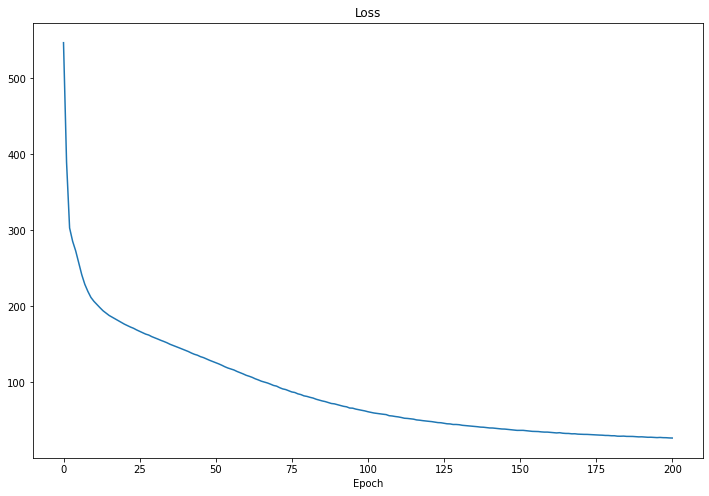

In [8]:
#from ngcf import NGCF

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)



# generate the NGCF-adjacency matrix
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

# create model name and save
modelname =  "NGCF" + \
    "_bs_" + str(batch_size) + \
    "_nemb_" + str(emb_dim) + \
    "_layers_" + str(layers) + \
    "_nodedr_" + str(node_dropout) + \
    "_messdr_" + str(mess_dropout) + \
    "_reg_" + str(reg) + \
    "_lr_"  + str(lr)

# create NGCF model
model = NGCF(data_generator.n_users, 
              data_generator.n_items,
              emb_dim,
              layers,
              reg,
              node_dropout,
              mess_dropout,
              adj_mtx)
if use_cuda:
    model = model.cuda()

# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

print("Start at " + str(today))
print("Using " + str(device) + " for computations")
print("Params on CUDA: " + str(next(model.parameters()).is_cuda))

results = {"Epoch": [],
            "Loss": [],
            "Recall": [],
            "NDCG": [],
            "Training Time": []}

for epoch in range(argsn_epochs):

    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    model.nowepoch += 1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
        format(epoch, training_time, loss))

    # print test evaluation metrics every N epochs (provided by args.eval_N)
    if epoch % argseval_N  == (argseval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach(),
                                      model.i_g_embeddings.detach(),
                                      data_generator.R_train,
                                      data_generator.R_test,
                                      k)
        print(
            "Evaluate current model:\n",
            "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            "Loss: {:.4f}:".format(loss), "\n",
            "Recall@{}: {:.4f}".format(k, recall), "\n",
            "NDCG@{}: {:.4f}".format(k, ndcg)
            )

        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=50)

        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)
    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)

    if should_stop == True: break

# save
if argssave_results:
    date = today.strftime("%d%m%Y_%H%M")

    # save model as .pt file
    if os.path.isdir("./models"):
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")
    else:
        os.mkdir("./models")
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir("./results"):
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    else:
        os.mkdir("./results")
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')